Part 2

12. DenseNet121

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2 as cv

from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
import os

Data preprocessing

In [4]:
# Set the base directory for the Jute Pest Dataset and define image parameters
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

# Set the base directory for the Jute Pest Dataset
# Update the path according to your dataset location in Google Drive
base_dir = "/content/drive/My Drive/Jute_Pest_Dataset"
batch_size = 32
img_height = 224
img_width = 224

# Define directories for training, validation, and test datasets
train_dir = f'{base_dir}/train'
val_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'

# Load and preprocess the training dataset with specified image size and batch size
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Save the class names from the training dataset for reference
class_names = train_ds.class_names

# Load and preprocess the validation dataset with the same parameters
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Load and preprocess the test dataset, using similar parameters
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Define data augmentation layer with random transformations to improve model generalization
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    keras.layers.RandomRotation(0.2),                    # Apply random rotation to images
    keras.layers.RandomZoom(0.2),                        # Zoom images randomly
    keras.layers.RandomContrast(0.1)                     # Adjust image contrast randomly
])

# Apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

Mounted at /content/drive
Found 6439 files belonging to 17 classes.
Found 413 files belonging to 17 classes.
Found 379 files belonging to 17 classes.


13,14,15,16

In [5]:
# Set parameters
img_height = 224
img_width = 224
num_classes = 17

batch_epochs = 5  # Train 10 epochs at a time
total_epochs = 10  # Initial training: 10 epochs
fine_tune_total_epochs = 10  # Fine-tuning: 10 epochs

# Load the pre-trained ResNet50 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze base model's layers

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Directory to save model checkpoints
checkpoint_dir = "model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Resume from the latest checkpoint if exists
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    print(f"Resuming from checkpoint: {latest_checkpoint}")
    model = tf.keras.models.load_model(latest_checkpoint)
    initial_epoch = int(latest_checkpoint.split('_')[-1].split('.')[0])  # Extract epoch number
else:
    print("No checkpoint found, starting from scratch.")
    initial_epoch = 0

# Initial Training: Train in chunks of 10 epochs
for start_epoch in range(initial_epoch, total_epochs, batch_epochs):
    end_epoch = min(start_epoch + batch_epochs, total_epochs)
    print(f"Training initial epochs {start_epoch + 1} to {end_epoch}...")

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        initial_epoch=start_epoch,
        epochs=end_epoch
    )

    checkpoint_path = os.path.join(checkpoint_dir, f"model_initial_epoch_{end_epoch}.h5")
    model.save(checkpoint_path)
    print(f"Model saved to {checkpoint_path}")

# Fine-Tuning: Unfreeze some layers and re-train
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Freeze all but the last 10 layers
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tuning: Train in chunks of 10 epochs
for start_epoch in range(total_epochs, total_epochs + fine_tune_total_epochs, batch_epochs):
    end_epoch = min(start_epoch + batch_epochs, total_epochs + fine_tune_total_epochs)
    print(f"Fine-tuning epochs {start_epoch + 1} to {end_epoch}...")

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        initial_epoch=start_epoch,
        epochs=end_epoch
    )

    checkpoint_path = os.path.join(checkpoint_dir, f"model_finetune_epoch_{end_epoch}.h5")
    model.save(checkpoint_path)
    print(f"Model saved to {checkpoint_path}")


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
No checkpoint found, starting from scratch.
Training initial epochs 1 to 5...
Epoch 1/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 1433s 7s/step - accuracy: 0.1060 - loss: 4.1250 - val_accuracy: 0.2446 - val_loss: 2.4836
Epoch 2/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 1432s 7s/step - accuracy: 0.1913 - loss: 2.5669 - val_accuracy: 0.2857 - val_loss: 2.3079
Epoch 3/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 1385s 7s/step - accuracy: 0.2391 - loss: 2.3861 - val_accuracy: 0.2809 - val_loss: 2.1801
Epoch 4/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 1401s 7s/step - accuracy: 0.2570 - loss: 2.2732 - val_accuracy: 0.3705 - val_loss: 2.0830
Epoch 5/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 1421s 7s/step - accuracy: 0.2903 - loss: 2.1571 - val_accuracy: 0.3850 - val_loss: 1.9807


Model saved to model_checkpoints/model_initial_epoch_5.h5
Training initial epochs 6 to 10...
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1340s 7s/step - accuracy: 0.3214 - loss: 2.0588 - val_accuracy: 0.4140 - val_loss: 1.9273
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1343s 7s/step - accuracy: 0.3420 - loss: 2.0205 - val_accuracy: 0.3898 - val_loss: 1.9157
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1345s 7s/step - accuracy: 0.3578 - loss: 1.9302 - val_accuracy: 0.4140 - val_loss: 1.9061
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1424s 7s/step - accuracy: 0.3634 - loss: 1.8813 - val_accuracy: 0.4286 - val_loss: 1.8535
Epoch 10/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1352s 7s/step - accuracy: 0.3777 - loss: 1.8834 - val_accuracy: 0.4455 - val_loss: 1.8714


Model saved to model_checkpoints/model_initial_epoch_10.h5
Fine-tuning epochs 11 to 15...
Epoch 11/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 1381s 7s/step - accuracy: 0.1353 - loss: 3.4348 - val_accuracy: 0.2809 - val_loss: 2.3643
Epoch 12/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 1424s 7s/step - accuracy: 0.1817 - loss: 2.8276 - val_accuracy: 0.3172 - val_loss: 2.2376
Epoch 13/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 1375s 7s/step - accuracy: 0.2118 - loss: 2.5696 - val_accuracy: 0.3487 - val_loss: 2.1282
Epoch 14/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 1442s 7s/step - accuracy: 0.2388 - loss: 2.4165 - val_accuracy: 0.3632 - val_loss: 2.0542
Epoch 15/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 1371s 7s/step - accuracy: 0.2689 - loss: 2.2692 - val_accuracy: 0.3608 - val_loss: 2.0047


Model saved to model_checkpoints/model_finetune_epoch_15.h5
Fine-tuning epochs 16 to 20...
Epoch 16/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 1359s 7s/step - accuracy: 0.2983 - loss: 2.2003 - val_accuracy: 0.3753 - val_loss: 1.9708
Epoch 17/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 1412s 7s/step - accuracy: 0.3014 - loss: 2.1251 - val_accuracy: 0.4068 - val_loss: 1.9477
Epoch 18/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 1361s 7s/step - accuracy: 0.3083 - loss: 2.1119 - val_accuracy: 0.4310 - val_loss: 1.9305
Epoch 19/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 1368s 7s/step - accuracy: 0.3297 - loss: 2.0544 - val_accuracy: 0.4383 - val_loss: 1.9150
Epoch 20/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 1365s 7s/step - accuracy: 0.3402 - loss: 2.0331 - val_accuracy: 0.4383 - val_loss: 1.9035


Model saved to model_checkpoints/model_finetune_epoch_20.h5


In [6]:
final_model_path = '/content/drive/My Drive/TrainedModel.h5'
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

Final model saved to /content/drive/My Drive/TrainedModel.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 76s 6s/step - accuracy: 0.4811 - loss: 1.7508
Test Accuracy of fine-tuned ResNet-50: 0.46
Test Loss of fine-tuned ResNet-50: 1.76


[]

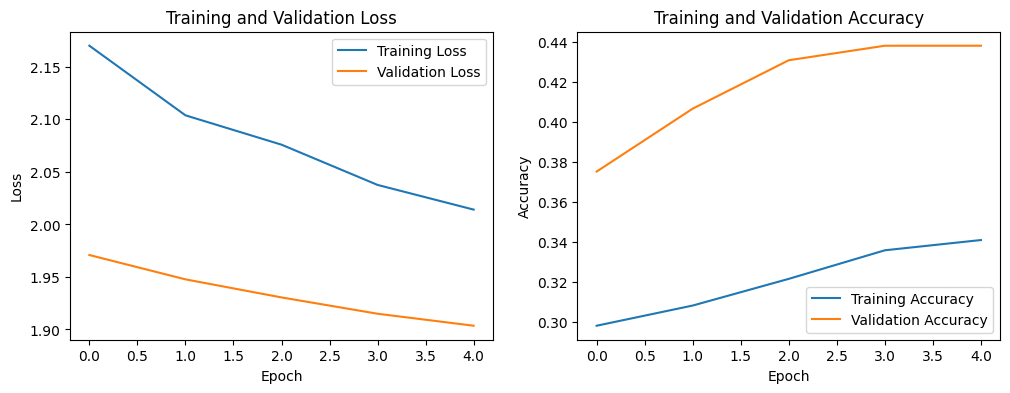

In [7]:
import matplotlib.pyplot as plt

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy of fine-tuned ResNet-50: {test_accuracy:.2f}")
print(f"Test Loss of fine-tuned ResNet-50: {test_loss:.2f}")

# Record losses and accuracy for plotting
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.plot()